# Metody probabilistyczne

## Konfiguracja

Użyjemy bardzo standardowych narzędzi, tych samych, co na laboratorium 3.

In [1]:
# !pip install numpy scipy pandas matplotlib scikit-learn pyarrow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Detekcja spamu

Najpierw wykorzystamy klasyfikator Naiwnego Bayesa do klasyfikacji binarnej długich tekstów - czy email jest spamem, czy też nie (tzw. "ham"). Takie zadanie nazywa się też spam/ham classification. Zbiorem będzie [Enron Spam dataset](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html), zebrany na potrzeby artykułu:

> Metsis, Vangelis, Ion Androutsopoulos, and Georgios Paliouras. *"Spam filtering with Naive Bayes - which Naive Bayes?."* CEAS. Vol. 17. 2006. [link](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf)

[Upadek firmy energetycznej Enron](https://userweb.cs.txstate.edu/~v_m137/docs/papers/ceas2006_paper_corrected.pdf) i skandal wywołany wiadomościami o nieprawidłowościach finansowych spowodowały, że podczas śledztwa i procesu zmuszono firmę do upublicznienia pełnej zawartości skrzynek mailowych 150 pracowników. Jest to doskonałe źródło prawdziwych danych, typowych emaili niebędących spamem, i było wykorzystywane wielokrotnie na potrzeby tworzenia wielu różnych zbiorów danych. Na potrzeby powyższego artykułu wybrano 6 pracowników z dużą liczbą emaili.

Maile będące spamem otrzymano z 4 różnych źródeł:
1. [Zbioru danych SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/) - stworzony z pomocą [Apache SpamAssassin](https://spamassassin.apache.org/), narzędzia open source do detekcji spamu. Maile niebędące spamem są w nim bardzo specyficzne (pochodzą ze skrzynek fundacji Apache i dotyczą praktycznie tylko programownaia), za to spam jest uniwersalny.
2. [Project Honeypot](https://www.projecthoneypot.org/) - projekt mający na celu wykrywanie spammerów (w tym przez specjalne pułapki, tzw. spam baiting) i tworzenie baz do filtrowania spamu.
3. [Bazę spamu Bruce'a Guentera](http://untroubled.org/spam/) - gromadzi on cały spam, który dostaje na skrzynki (w tym takie do spam baitingu) od 1997 roku.
4. Maile ze spamem zgromadzone przez trzeciego autora artykułu, Georgiosa Paliourasa.

Artykuł prezentuje spersonalizowane kolekcje maili, dla każdego z 6 wybranych pracowników Enronu. My natomiast połączymy wszystkie dane i stworzymy prosty, uniwersalny filtr. Nasz filtr będzie operował tylko na tytułach i treści maili - prawdziwe systemy są dużo bardziej rozbudowane i wykorzystują metadane, bazy adresów, analizę tagów HTML i XML etc.

Wykorzystamy przetworzoną postać tego zbioru w postaci pliku CSV z interesującymi nas elementami. Skrypt do tego wzięto [z tego repozytorium na Githubie](https://github.com/MWiechmann/enron_spam_data?fbclid=IwAR1icPxic8TDD6HGk6empohwcZ76uig0NxwxK7sWbczinBNfxEEt-ETparA).

In [3]:
df = pd.read_csv("enron_spam_data.csv")
df

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


Na pierwszy rzut oka widać parę problemów:
- kolumny `Message ID` i `Date` są niepotrzebne
- niektóre wiadomości mają tylko tytuł lub tylko wiadomość
- klasa jest zapisana jako string spam/ham

**Zadanie 1 (0.5 punktu)**

1. Uzupełnij wartości brakujące w kolumnach `Subject` i `Message` pustymi stringami.
2. Połącz kolumny `Subject` i `Message` w jedną kolumnę `text`, ze spacją pomiędzy nimi. Może się przydać metoda `pd.Series.str.cat()`. Wyodrębnij ją do nowej zmiennej `texts`.
3. Zamień wartość `ham` na 0 i `spam` na 1 w kolumnie `Spam/Ham`. Wyodrębnij ją do nowej zmiennej `y`.

In [4]:
df = df.drop(
    columns=["Message ID", "Date"]
)  # wprawdzie nie było w treści polecenia, ale wyżej jest napisane że są są niepotrzebne
df.fillna({"Subject": "", "Message": ""}, inplace=True)

In [5]:
texts = df["Subject"].str.cat(df["Message"], sep=" ")
texts

0                            christmas tree farm pictures 
1        vastar resources , inc . gary , production fro...
2        calpine daily gas nomination - calpine daily g...
3        re : issue fyi - see note below - already done...
4        meter 7268 nov allocation fyi .\n- - - - - - -...
                               ...                        
33711    = ? iso - 8859 - 1 ? q ? good _ news _ c = eda...
33712    all prescript medicines are on special . to be...
33713    the next generation online pharmacy . are you ...
33714    bloow in 5 - 10 times the time learn how to la...
33715    dear sir , i am interested in it hi : )\ndo yo...
Name: Subject, Length: 33716, dtype: object

In [6]:
df["Spam/Ham"] = df["Spam/Ham"].replace({"ham": 0, "spam": 1})
y = df.pop("Spam/Ham")

In [7]:
y

0        0
1        0
2        0
3        0
4        0
        ..
33711    1
33712    1
33713    1
33714    1
33715    1
Name: Spam/Ham, Length: 33716, dtype: int64

Sprawdźmy jeszcze rozkład klas.

[Text(0, 0, '50.93'), Text(0, 0, '49.07')]

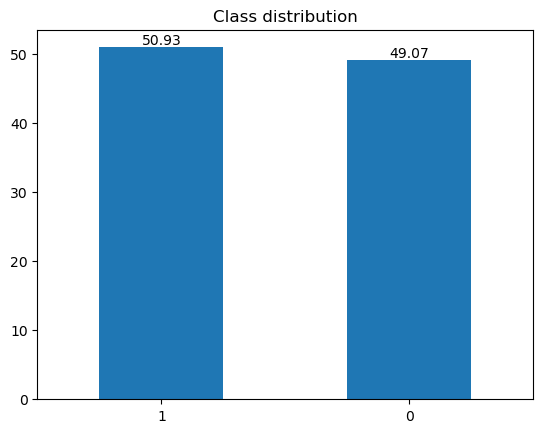

In [8]:
class_percentages = y.value_counts(normalize=True)
class_percentages = round(class_percentages * 100, 2)

ax = class_percentages.plot.bar(title="Class distribution", rot=0)

ax.bar_label(ax.containers[0])

Ten zbiór w całości jest o tyle specyficzny, że dodano tutaj aż tyle spamu, że jest go nawet więcej niż zwykłych emaili. W praktyce spamu jest dużo mniej, ok. 1/3 maili. Tutaj uznajemy, że klasy są zbalansowane.

Typową metryką w klasyfikacji spamu jest **precyzja (precision)**, bo wyznacza ona, jak dobrzy jesteśmy w oznaczaniu spamu. Recall ma mniejsze znaczenie, bo bardziej zależy nam na minimalizacji FP - ważne maile nie mogą trafiać do spamu, natomiast jeżeli spam czasem trafi do zwykłej skrzynki (FN), to nie ma wielkiego znaczenia. Często używa się też F1-score jako metryki.

W przypadku tych metryk (precision/recall/F1-score) zawsze trzeba sprawdzić co najmniej dwie z nich, żeby uniknąć przypadkiem sytuacji, że mamy np. precision bliskie 100%, a dramatycznie niski recall - to też nie byłoby akceptowalne. Trzeba też uważać podczas walidacji skrośnej - np. klasyfikator przewidujący cały czas klasę pozytywną miałby 100% recall, a cały czas negatywną 100% precision, więc typowo najwygodniej jest optymalizować F1-score.

Na początek podzielimy zbiór na treningowy i testowy, a potem użyjemy klasy `CountVectorizer` ([dokumentacja](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)), żeby zliczyć słowa. Teraz jednak podamy `binary=True`, dzięki czemu cechy będą binarne - czy słowo wystąpiło, czy nie. Dzięki temu będziemy mogli użyć Naiwnego Bayesa z rozkładem dwumianowym - `BernoulliNB`. Wykonamy minimalny preprocessing, usuwając tylko stop words.

Zauważ, że wejściem do metody `.fit()` jest lista tekstów, ze względu a domyślne `input="content"`. Można by tu też wskazać listę ścieżek do plików z tekstami (`input="filename"`).

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


texts_train, texts_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

count_vectorizer = CountVectorizer(
    stop_words="english",
    binary=True,
)
count_vectorizer.fit(texts_train)

X_train = count_vectorizer.transform(texts_train)
X_test = count_vectorizer.transform(texts_test)

print(f"Dictionary size: {X_train.shape[1]}")

clf_nb_bernoulli = BernoulliNB(binarize=None)
clf_nb_bernoulli.fit(X_train, y_train)

y_pred = clf_nb_bernoulli.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Dictionary size: 139189
Precision: 98.92%
F1-score: 98.46%


Wynik jest prawie doskonały. Może uda się jeszcze wycisnąć ten ostatni procent?

**Zadanie 2 (2 punkty)**

1. Oblicz wystąpienia słów bez binaryzacji, otrzymując drugi zbiór cech.
2. Wytrenuj model multinomial Naive Bayes na otrzymanym zbiorze. Sprawdź precyzję i F1-score na zbiorze testowym.
3. Stwórz `Pipeline` z połączenia `CountVectorizer` i `MultinomialNB`. Podaj te opcje, co wcześniej do CountVectorizera.
4. Dokonaj tuningu hiperparametrów:
   - `ngram_range` - jakie n-gramy rozważać, sprawdź wartości `[(1, 1), (1, 2), (1, 3)]` (same słowa, + bigramy, + bigramy i trigramy)
   - `max_df` - w jakim maksymalnie ułamku tekstów w zbiorze może wystąpić słowo, sprawdź wartości `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`
   - wybierz model o najwyższej precyzji
   - użyj standardowych ustawień: 5-krotna walidacja skrośna, `n_jobs=-1`
   - sprawdź precyzję i F1-score na zbiorze testowym dla znalezionych optymalnych hiperparametrów
5. Wypisz optymalne hiperparametry. Sprawdź, jak zmienił się rozmiar słownika przy tych hiperparametrach.
6. Skomentuj uzyskane hiperparametry. Jaki zakres (kontekst) uwzględniamy przy takich n-gramach? Czy uwzględniamy wszystkie słowa/bigramy/trigramy?

**Uwaga:**
1. Do metody `.fit()` możesz przekazać `texts_train` i `y_train`. Jako że `CountVectorizer` ma interfejs transformera (ma metodę `.transform()`), to Scikit-learn przekształci nim teksty do macierzy `X_train` i to ją przekaże dalej do klasyfikatora.
2. Przy tworzeniu pipeline'u może się przydać [ta odpowiedź na StackOverflow](https://stackoverflow.com/a/64258746/9472066).
3. Pamiętaj, że do testowania też trzeba przekazać teksty, które przekształcimy w środku pipeline'u.

In [10]:
nonbinary_vectorizer = CountVectorizer(stop_words="english", binary=False)
nonbinary_vectorizer.fit(texts_train)

X_train = nonbinary_vectorizer.transform(texts_train)
X_test = nonbinary_vectorizer.transform(texts_test)
print(f"Second dictionary size: {X_train.shape[1]}")

Second dictionary size: 139189


In [11]:
from sklearn.naive_bayes import MultinomialNB

multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

y_pred = multinomial_nb.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Precision: 98.54%
F1-score: 98.71%


In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ("vect", CountVectorizer(stop_words="english", binary=False)),
        ("mult", MultinomialNB()),
    ]
)

In [13]:
from sklearn.model_selection import GridSearchCV

parametres = {
    "vect__max_df": (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    "vect__ngram_range": (
        (1, 1),
        (1, 2),
        (1, 3),
    ),
}

grid_search = GridSearchCV(
    estimator=pipeline, param_grid=parametres, scoring="precision", n_jobs=-1
)

grid_search.fit(texts_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('mult', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_df': (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                         'vect__ngram_range': ((1, 1), (1, 2), (1, 3))},
             scoring='precision')

In [14]:
y_pred = grid_search.predict(texts_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Precision: 99.32%
F1-score: 99.24%


In [15]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parametres: {best_params}")
print(f"Best score: {best_score}")

Best parametres: {'vect__max_df': 0.5, 'vect__ngram_range': (1, 3)}
Best score: 0.9942343763903155


In [16]:
vocabulary_size = len(grid_search.best_estimator_.named_steps["vect"].vocabulary_)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 3383053


// skomentuj tutaj

Uwzględniamy same słowa, bigramy i trigramy w zakresie 50%. Przez to że bierzemy pod uwagę n-gramy klasyfikator działa lepiej - przypadki typu "not good" - kiedy pojedyncze słowo "good" jest błędne

W przypadku tak wysokiego wyniku nie ma sensu sprawdzać ważenia TF-IDF - wynik jest tak wysoki, że ostatnie ułamki procent z dużym prawdopodobieństwem wymagają bardziej złożonego modelu. Inna sprawa, czy w ogóle warto byłoby po taki sięgać.

Dodatkowo warto zauważyć, że nie przeprowadziliśmy tutaj żadnej lematyzacji ani żadnego bardziej złożonego preprocessingu. W przypadku tak wysokich wyników zwyczajnie nie ma to szczególnego sensu.

## Klasyfikacja tematu artykułu

Naszym drugim zbiorem danych będzie [AG News Classification dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset). [Pełny zbiór AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) został zebrany przez Antonio Gulliego (obecnie Director of Engineering w Google) i obejmuje 1 milion artykułów, zebranych z ponad 2000 źródeł danych w silniku ComeToMyHead. Podzbiór AG News Classification został z niego wybrany na potrzeby artykułu:

> Zhang, Xiang, Junbo Zhao, and Yann LeCun. *"Character-level convolutional networks for text classification."* Advances in neural information processing systems 28 (2015). [link](https://proceedings.neurips.cc/paper/2015/file/250cf8b51c773f3f8dc8b4be867a9a02-Paper.pdf)

Zbiór składa się przede wszystkim z tytułów i treści artykułów z newsami, z 4 najpopularniejszych w zbiorze AG News kategorii: "World", "Sports", "Business", "Sci/Tech". Automatyczne tagowanie newsów jest ważne szczególnie dla stron-agregatorów, gdzie ręczna anotacja byłaby niemożliwa w czasie rzeczywistym.

Został on wybrany tak, żeby klasy były zbalansowane zarówno w zbiorze treningowym, jak i testowym. Metryką jest celność (accuracy). Jest on już też z góry podzielony, dla odpowiedniej reprodukowalności wyników. Nie ma też wartości brakujących - ogółem jakość danych jest niesamowicie wysoka.

**Zadanie 3 (0.5 punktu)**

1. Wczytaj zbiór treningowy i testowy z plików `ag_news_data_train.parquet` oraz `ag_news_data_test.parquet`.
2. Połącz tytuł i opis, łącząc je spacją. Wyodrębnij teksty do osobnych zmiennych `texts_train` i `texts_test`.
3. Wyodrębnij klasy do osobnych zmiennych `y_train` i `y_test`. Są one numerowane od 1 do 4 - zmapuj je zamiast tego tak, żeby były od 0 do 3.
4. Sprawdź liczność zbioru treningowego oraz testowego.

In [17]:
ag_train = pd.read_parquet("ag_news_data_train.parquet")
ag_test = pd.read_parquet("ag_news_data_test.parquet")

ag_train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [18]:
texts_train = ag_train["Title"].str.cat(ag_train["Description"], sep=" ")
texts_test = ag_test["Title"].str.cat(ag_test["Description"], sep=" ")

In [19]:
y_train = ag_train["Class Index"].replace({i + 1: i for i in range(4)})
y_test = ag_test["Class Index"].replace({i + 1: i for i in range(4)})

In [20]:
print(f"Train set size {texts_train.shape[0]}\nTest set size: {texts_test.shape[0]}")

Train set size 120000
Test set size: 7600


Teraz możemy się zająć klasyfikacją tekstu. Autorzy w artykule używają i zwykłego zliczania słów, i wersji z TF-IDF. Ograniczają też rozmiar słownika do maksymalnie 500000 słów, co jest też dość częstą praktyką - nieograniczone słowniki mogą łatwo eksplodować rozmiarem na bardzo dużych zbiorach danych, a większość z tych cech jest wtedy raczej kiepska.

Autorzy w artykule używają regresji logistycznej, dlatego skalują wartości cech TF-IDF do zakresu [0, 1]. My musimy sprecyzować `norm=None`, żeby nie zastosować żadnej dodatkowej normalizacji - Naive Bayes nie zakłada żadnej jako model.

**Zadanie 4 (2 punkty)**

1. Przygotuj pipeline'y (pamiętaj o ograniczeniu słownika, czyli maksymalnej liczby cech, do 500000):
   - `CountVectorizer` z binaryzacją cech + `BernoulliNB`
   - `CountVectorizer` bez binaryzacji cech + `MultinomialNB`
   - `TfidfVectorizer` + `MultinomialNB` (pamiętaj o `norm=None`
2. Wytrenuj modele i przetestuj je, podając celność (accuracy) na zbiorze testowym.
3. Skomentuj, który model poradził sobie najlepiej. W artykule regresja logistyczna osiąga celność 89,64% w wersji z TF-IDF. Czy nasz Naive Bayes jest lepszy? Czy z rezultatów wynika, że do klasyfikacji wystarczy samo występowanie / nie występowanie określonych słów?

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

p1 = Pipeline(
    [
        (
            "vect",
            CountVectorizer(stop_words="english", binary=True, max_features=500000),
        ),
        ("nb", BernoulliNB()),
    ]
)

p2 = Pipeline(
    [
        ("vect", CountVectorizer(stop_words="english", max_features=500000)),
        ("nb", MultinomialNB()),
    ]
)

p3 = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words="english", norm=None, max_features=500000)),
        ("nb", MultinomialNB()),
    ]
)

names = [
    "CountVectorizer+BernoulliNB",
    "CountVectorizer+MultinomialNB",
    "TfidfVectorizer+MultinomialNB",
]

pipelines = zip([p1, p2, p3], names)

In [22]:
from sklearn.metrics import accuracy_score

for p, name in pipelines:
    p.fit(texts_train, y_train)
    y_pred = p.predict(texts_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy-score: {100 * accuracy:.2f}%")

CountVectorizer+BernoulliNB accuracy-score: 89.97%
CountVectorizer+MultinomialNB accuracy-score: 90.45%
TfidfVectorizer+MultinomialNB accuracy-score: 90.46%


// skomentuj tutaj

Najlepiej poradził sobie model z TF-IDF i Multinomial NB. Osiągnął wynik około 1% lepszy niż regresja logistyczna z artykułu. Na podstawie tych wyników możnaby powiedzieć że wystarczy samo występowanie/nie występowanie określonych słów - ale tylko na podstawie tych wyników, możliwe że akurat w tej sytuacji to wystarczyło

Wyniki są niezłe, natomiast według artykułu użycie n-gramów daje jeszcze lepsze wyniki. Tam dla regresji logistycznej wybrano n-gramy z zakresu od 1 do 5, z maksymalnym rozmiarem słownika 500000. Nie mamy jednak gwarancji, że są to wartości optymalne dla naszego Naive Bayesa, plus wyżej niż 3-gramy rzadko coś daje.

Nasz zbiór treningowy jest bardzo duży, więc nie ma potrzeby używania walidacji skrośnej - zwykły holdout da dość dobre wyniki. Jeżeli mamy gotowy zbiór treningowy, to najprościej w tym celu użyć `ShuffleSplit` z 1 losowaniem zbioru walidacyjnego.

**Zadanie 5 (1 punkt)**

1. Dokonaj tuningu pipeline'u TF-IDF + multinomial Naive Bayes:
   - `ngram_range` - zakres wartości `[(1, 1), (1, 2), (1, 3)]`
   - `max_features` - zakres wartości `[500000, None]`
   - maksymalna liczba cech (rozmiar słownika) to 500000
   - użyj jednego zbioru walidacyjnego, stanowiącego 25% danych treningowych, z pomocą `ShuffleSplit`; pamiętaj o `random_state=0`
   - wybierz model o najwyższym accuracy
   - ustaw `n_jobs=1`, bo inaczej może ci łatwo zabraknąć pamięci
   - pamiętaj o `random_state=0`
2. Sprawdź wyniki na zbiorze testowym dla najlepszych hiperparametrów. Czy udało się uzyskać wynik lepszy od tych z artykułu dla n-gramów (patrz tabela na stronie 6 artykułu)?

In [23]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

parametres = {
    "vect__ngram_range": (
        (1, 1),
        (1, 2),
        (1, 3),
    ),
    "vect__max_features": [500000, None],
}

grid_search = GridSearchCV(
    estimator=p3,
    param_grid=parametres,
    cv=rs,
    scoring="accuracy",
    n_jobs=1,
)

grid_search.fit(texts_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=500000,
                                                        norm=None,
                                                        stop_words='english')),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'vect__max_features': [500000, None],
                         'vect__ngram_range': ((1, 1), (1, 2), (1, 3))},
             scoring='accuracy')

In [24]:
y_pred = grid_search.predict(texts_test)
accuracy = accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_
print(f"Tuned TF-IDF accuracy-score: {100 * accuracy:.2f}%")
print(f"Best parametres: {best_params}")

Tuned TF-IDF accuracy-score: 91.78%
Best parametres: {'vect__max_features': 500000, 'vect__ngram_range': (1, 2)}


// skomentuj tutaj

Wynik jest bardzo zbliżony do tego z artykułu

## Dane z ekspresji genów

Naszym ostatnim zbiorem będzie [GSE2034](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse2034) ([Mendeley Data](https://data.mendeley.com/datasets/v3cc2p38hb/1), [Kaggle](https://www.kaggle.com/datasets/saurabhshahane/gene-expression-profiles-of-breast-cancer)). Jest to zbiór ekspresji genów z sekwencjonowania RNA, zebrany na potrzeby artykułu:

> Wang, Yixin, et al. *"Gene-expression profiles to predict distant metastasis of lymph-node-negative primary breast cancer."* The Lancet 365.9460 (2005): 671-679. [link](https://www.ihes.fr/~zinovyev/princmanif2006/Wang_lancet_2005.pdf)

Zbiór ten został stworzony z danych pochodzących z sekwencjonowania RNA 286 pacjentek chorych na nowotwór piersi bez przerzutów do węzłów chłonnych ([lymph node-negative breast cancer](https://www.komen.org/breast-cancer/diagnosis/stages-staging/lymph-node-status/)). Celem było sprawdzenie, czy na podstawie analizy genetycznej można przewidzieć, czy nastąpi odległa metastaza nowotworu ([distant metastatis](https://training.seer.cancer.gov/staging/systems/summary/distant.html)), czyli przerzuty nowotworu przez krew do odległych części ciała. Takie przypadki uznaje się za porażkę w leczeniu nowotworu. Według źródeł z artykułu, ok. 85-90% pacjentek jest poddawane dodatkowej terapii (np. chemoterapii) po operacji usunięcia nowotworu, natomiast personalizowana medycyna oparta o analizę genetyczną pozwoliłaby nie tylko oszczędzić tego leczenia (z ciężkimi skutkami ubocznymi) niektórym pacjentkom, ale też skupić się bardziej na innych, z większym ryzykiem przerzutów.

Cechy w tym zbiorze to poziom ekspresji 12634 genów w sekwencjonowanym RNA. Ekspresja genu ([gene expression](https://en.wikipedia.org/wiki/Gene_expression)) to proces tłumaczenia informacji genetycznej z genu (sekwencji DNA) do białek (przez kodujące RNA) lub innych funkcji (przez niekodujące RNA). Im silniejsza ekspresja genu, tym więcej materiału (zwykle białek / protein) produkuje dany gen w danym organizmie. Jest to najmniejszy molekularnie poziom, na którym można zaobserwować fenotyp, czyli cechy stworzone na podstawie genotypu.

Oprogramowanie do analizy ekspresji genów dokonuje od razu standaryzacji poziomu ekspresji każdego z genów. W związku dla każdego z genów mamy jego Z-score, czyli wartość cechy oznacza, o ile odchyleń standardowych jego wartość różni się od średniej ekspresji tego genu wśród wszystkich próbek. Jest to wygodne do analiz biomedycznych, bo pozwala bezpośrednio porównywać ze sobą pacjentów. Przy okazji jest też wygodne do uczenia maszynowego.

Zmienną do przewidywania jest tutaj, czy nastąpi nawrót nowotworu i przerzuty w ciągu 5 lat od operacji (to podczas niej pobiera się tkankę nowotworową do badań genetycznych). Warto zwrócić uwagę, że mamy tutaj 286 pacjentek, a ponad 12 tysięcy cech, a zatem $n >> d$.

W przypadku danych medycznych typowo optymalizowaną metryką jest **czułość (recall)**, ponieważ zależy nam na tym, żeby minimalizować przypadki FN. Oznaczają one brak wykrycia choroby, co ma tragiczne skutki, w przeciwieństwie do FP, które może mieć co prawda negatywne skutki (np. dodatkowe badania, niepotrzebne leczenie ze skutkami ubocznymi), ale typowo mniejsze. Oczywiście dalej trzeba sprawdzić F1-score.

**Zadanie 6 (0.5 punktu)**

1. Wczytaj dane z plików `GSE2034-Normal.tsv` oraz `GSE2034-Tumor.tsv`. Są one w formacie TSV, czyli CSV, ale z tabami (`\t`) zamiast przecinków.
2. Usuń kolumnę `Hybridization REF` z obu ramek.
3. Obecnie kolumny to pacjentki, a wiersze to ekspresje genów. Dokonaj transpozycji (transpose) DataFrame'ów tak, aby kolumnami były cechy.
4. Połącz oba DataFrame'y w jedną tablicę Numpy'a `X`, reprezentującą cały zbiór danych.
5. Stwórz wektor klas `y`, mający wartości 0 dla wierszy z pliku `Normal` i wartość 1 dla wierszy z pliku `Tumor`.
6. Narysuj wykres częstości klas.

In [37]:
normal = pd.read_csv("GSE2034-Normal.tsv", sep="\t")
tumor = pd.read_csv("GSE2034-Tumor.tsv", sep="\t")
normal = normal.drop(columns=["Hybridization REF"])
tumor = tumor.drop(columns=["Hybridization REF"])
normal.head()

,GSM36778,GSM36784,GSM36789,GSM36792,GSM36797,GSM36800,GSM36811,GSM36813,GSM36814,GSM36815,...,GSM37039,GSM37040,GSM37041,GSM37042,GSM37049,GSM37050,GSM37051,GSM37052,GSM37053,GSM37058
0,3.842881,4.841640,3.867088,3.721221,4.563904,4.031799,4.871149,4.762982,4.959105,4.868683,...,4.741835,5.346995,5.326351,3.775733,4.825607,6.068711,5.547313,4.862021,5.629515,4.834182
1,4.490332,2.621363,5.942069,6.299080,2.102310,4.876087,3.350784,5.863490,4.662885,4.729869,...,6.250711,0.910434,2.075095,1.505282,2.317741,1.145004,0.359255,1.098206,-0.053937,3.472645
2,-1.963620,-3.195066,-2.812142,-0.528041,-3.033733,-3.518126,-2.641600,-1.461283,-2.327163,-2.022420,...,-2.568842,-2.738044,-3.017984,-0.730068,-1.934196,-2.715258,-1.670424,-1.725600,-3.579188,-3.479302
3,4.064546,4.884428,7.407978,6.603281,5.704690,6.432289,7.678657,3.769442,2.721350,6.073213,...,5.359216,4.169598,5.474949,-1.135062,2.053827,2.421972,5.672133,3.808836,6.191514,4.730419
4,-2.288353,-3.089603,-3.935045,-3.072142,-1.852442,-3.012878,-2.349891,-2.566955,-3.054496,-1.065191,...,-2.088698,-2.031275,-0.417617,-2.426974,-1.281003,-0.619035,-4.057609,-0.323826,-3.072927,-0.736423


In [38]:
normal = normal.T
tumor = tumor.T

In [39]:
X = pd.concat([normal, tumor]).to_numpy()
X

array([[ 3.842881  ,  4.49033201, -1.96361963, ..., -0.96040322,
         2.00663774, -0.12670777],
       [ 4.84164036,  2.62136266, -3.1950659 , ..., -2.72137873,
         1.46131289,  0.09332382],
       [ 3.86708826,  5.9420693 , -2.81214198, ..., -1.36969611,
         1.2415015 ,  1.29188094],
       ...,
       [ 4.51733089,  3.16081496, -3.27828599, ..., -1.03890648,
         0.5272178 ,  0.38335094],
       [ 4.20259979,  6.70409891, -0.2885533 , ..., -2.4364532 ,
         0.35435984,  0.69198999],
       [ 4.43914853,  5.56715424, -3.01784035, ..., -0.75637574,
         0.12805997,  0.07258426]])

In [49]:
n = np.zeros(normal.shape[0], dtype=int)
t = np.ones(tumor.shape[0], dtype=int)
y = np.concatenate([n, t])

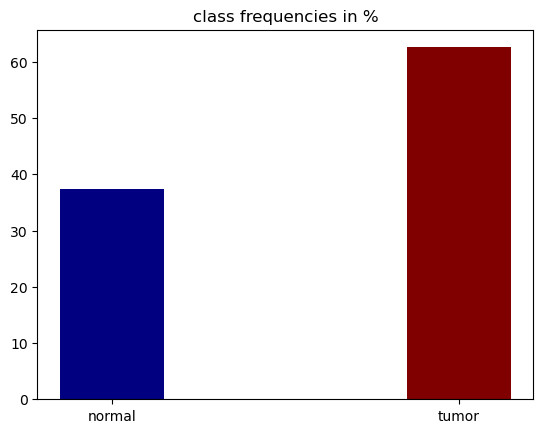

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.bar(
    ["normal", "tumor"],
    [100 * n.size / y.size, 100 * t.size / y.size],
    color=["navy", "maroon"],
    width=0.3,
)
plt.title("class frequencies in %")
plt.show()

Jak widać, mamy więcej przykładów pozytywnych niż negatywnych. Jest to dość częste w zbiorach medycznych, które są często tworzone bardziej do analizy przypadków chorobowych, niż do tworzenia modeli predykcyjnych. Oczywiście to, że klasy pozytywnej jest więcej, wcale nie oznacza, że klasyfikacja musi być prostsza.

Jako że nasze cechy są ciągłe, to musimy użyć klasyfikatora Naiwnego Bayesa z założeniem rozkładu normalnego do klasyfikacji. Dokonamy podziału na zbiór treningowy i testowy w proporcjach 67%-33%.

In [53]:
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=0,
    stratify=y,
)

clf_nb_gaussian = GaussianNB()
clf_nb_gaussian.fit(X_train, y_train)

y_pred = clf_nb_gaussian.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Recall: 64.41%
F1-score: 68.47%


Wyniki są co najwyżej mocno przeciętne. Można powiedzieć, że mamy tu underfitting, ale przy tej ilości danych (zbiór treningowy ma ok. 200 próbek) użycie dużo pojemniejszego modelu mogłoby się łatwo skończyć się mocnym overfittingiem.

Może to nasze założenia co do normalności klas są błędne? Sprawdźmy to dla kilku pierwszych cech.

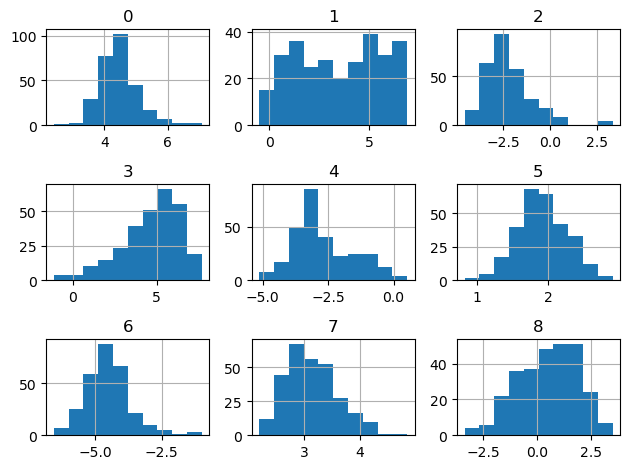

In [54]:
pd.DataFrame(X[:, :9]).hist()
plt.tight_layout()
plt.show()

O ile niektóre rozkłady nieco przypominają normalny, co tłumaczy nie najgorszy wynik klasyfikatora, to jednak daleko do pełnej normalności. Empiryczne oszacowanie rozkładu za pomocą Kernel Density Estimation (KDE) powinno poprawić wynik w takiej sytuacji.

Scikit-learn nie ma gotowego Naive Bayesa z KDE, ale łatwo go zaimplementować. W tym celu trzeba stworzyć własny klasyfikator. Robi się w skrócie to tak ([dokładny tutorial](https://scikit-learn.org/stable/developers/develop.html)):
1. Tworzymy klasę dziedziczącą po `BaseEstimator`, `ClassifierMixin` oraz ewentualnie innych klasach, które nas interesują.
2. Wszystkie hiperparametry są argumentami konstruktora. Każdy jest przypisywany, bez żadnych zmian, do atrybutu o dokładnie tej samej nazwie.
3. Implementujemy metody `.fit(X, y)`,`.predict(X)`, oraz ewentualnie `.predict_proba(X)`. Metoda `.fit()` musi zwracać `self`.
4. Na początku metody `.fit(X, y)` używamy funkcji `check_X_y()`, żeby dokonać podstawowej walidacji wejścia. Na początku metody `.predict(X)` analogicznie używamy funkcji `check_array()` na wejściu `X`.

Taki interfejs gwarantuje, że nasz własny model będzie mógł być używany np. w `GridSearchCV`.

**Zadanie 7 (2.5 punktu)**

Uzupełnij implementację klasy `KernelDensityEstimationNB`, realizującej algorytm KDE Naive Bayes.

1. Zakładamy, że klasy są liczbami całkowitymi, z wartościami `[0, 1, ..., liczba klas - 1]`.
2. Rozkład a priori (prior) dla każdej klasy to proporcja tej klasy w zbiorze treningowym. Naive Bayes używa log-sum-exp trick, więc można od razu obliczyć logarytm i zapisać log-prior.
3. Każda klasa ma swój model Kernel Density Estimation, wytrenowany na przykładach z tej klasy.
4. Podczas predykcji trzeba obliczyć, dla każdej z nowych próbek do zaklasyfikowania, jej wiarygodność (likelihood) dla każdej z klas. Służy do tego metoda `.score_samples()`. Ze względu na log-sum-exp trick ponownie oblicza się logarytm, otrzymując log-likelihood.
5. Dla każdego z przykładów, dla każdej z klas, sumujemy log-prior i log-likelihood, otrzymując wartość rozkładu a posteriori (posterior). Zgodnie z zasadą maximum a posteriori (MAP), wybieramy klasę o najwyższej z tych wartości. Może tu się przydać `np.argmax()`.

In [57]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.utils import check_array, check_X_y


class KernelDensityEstimationNB(BaseEstimator, ClassifierMixin):
    """
    Naive Bayes with KDE estimation of feature distributions.

    Parameters
    ----------
    kernel : str
        Kernel name, passed to KernelDensity

    bandwidth : float
        Kernel bandwidth
    """

    def __init__(self, kernel: str = "gaussian", bandwidth: float = 1.0):
        # create attributes
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, y):
        # make sure that we are working on Numpy arrays, and perform basic
        # sanity checks
        X = np.array(X)
        y = np.array(y)
        X, y = check_X_y(X, y)

        # make sure that y has values from 0 to num_classes - 1
        assert y.min() == 0
        assert y.max() == len(np.unique(y)) - 1

        # vector of possible classes
        self.classes_ = list(range(y.max() + 1))

        # vector for remembering class priors, i.e. proportion of classes
        # in the training set
        self.log_priors_ = np.empty(len(self.classes_))

        # list of KernelDensity models, one for each class
        self.kde_models_ = []

        for class_idx in self.classes_:
            # select X and y from the current class
            class_X = X[y == class_idx]

            # calculate log-prior, i.e. logarithm of current class proportion
            self.log_priors_[class_idx] = np.log(class_X.shape[0] / X.shape[0])

            # create and fit KernelDensity estimator, using given kernel and bandwidth
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
            kde.fit(class_X)

            # save KDE
            self.kde_models_.append(kde)

        return self

    def predict(self, X):
        # make sure that we are working on Numpy array, and perform basic
        # sanity checks
        X = np.array(X)
        X = check_array(X)

        # use KDE models and calculate log-likelihoods for each sample
        log_likelihoods = np.array([kde.score_samples(X) for kde in self.kde_models_])

        # calculate posterior probability: log-prior + log-likelihood
        # make sure that they have the same shape (transpose if needed)
        posteriors = self.log_priors_ + log_likelihoods.T

        # select the index of class with maximum a posteriori (MAP) rule
        map_class = np.argmax(posteriors, axis=1)

        return map_class

In [58]:
clf_nb_kde = KernelDensityEstimationNB()
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Recall: 84.75%
F1-score: 70.92%


W przypadku czułości (recall) jest już zdecydowanie lepiej! F1-score poprawił się, ale tylko trochę - precyzja mogłaby być lepsza. Ale KDE jest dość czułe na dobór szerokości (bandwidth) kernela, więc tuning hiperparametrów powinien tutaj pomóc.

Ciekawą opcją dla szerokości kernela jest **Silverman's rule of thumb**. Jest to prosty wzór na szerokość kernela przy założeniu, że rozkład jest unimodalny. Scikit-learn wspiera tę opcję przez przekazanie wartości `bandwidth="silverman"`. Wzór dla wielu cech ([Wikipedia](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Rule_of_thumb)):

$$
h_{silverman} = \left(\frac{4}{d+2}\right) n^{\frac{-1}{d+4}} \sigma
$$

Gdzie $\sigma$ to wektor odchyleń standardowych cech, $n$ to liczba próbek, a $d$ to liczba wymiarów.

Wadą implementacji w Scikit-learn jest to, że nie uwzględnia on odchyleń $\sigma$, więc bandwidth jest wspólny dla wszystkich cech. Jeżeli jednak są one w podobnej skali (tak jak w tym zbiorze), to nie stanowi to dużego problemu. No i w razie potrzeby można zawsze ustandardyzować dane.

Dla zainteresowanych - tuning kernel bandwidth to mocno badane przez matematyków zagadnienie, i istnieje do niego szereg rozbudowanych metod statystycznych. [Ten tutorial](https://aakinshin.net/posts/kde-bw/) jest chyba najlepszym i najbardziej czytelnym, a przy tym ma potężny przegląd literatury.

In [59]:
clf_nb_kde = KernelDensityEstimationNB(bandwidth="silverman")
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

class_0_bandwidth = clf_nb_kde.kde_models_[0].bandwidth_
class_1_bandwidth = clf_nb_kde.kde_models_[1].bandwidth_

print(f"Class bandwidths: {class_0_bandwidth:.4f}, {class_1_bandwidth:.4f}")

Recall: 86.44%
F1-score: 72.34%
Class bandwidths: 0.9990, 0.9990


Wynik się poprawił, a ilość pracy była minimalna. Jeżeli nasze rozkłady cech wyglądają na unimodalne i podobne do normalnego, to zasada Silvermana może w prosty i szybki sposób ulepszyć nasze wyniki.

Dodatkowo widać, że wyestymowany bandwidth jest bardzo bliski 1 (korekta jest zasadniczo kosmetyczna), więc w tym obszarze można ewentualnie szukać lepszych wartości hiperparametru.

**Zadanie 8 (1 punkt)**

1. Dokonaj tuningu hiperparametru `bandwidth`:
   - sprawdź 100 wartości na siatce liniowej w zakresie od 0.75 do 1.25
   - użyj kernela gaussowskiego
   - wybierz model o najwyższym F1-score
   - użyj standardowych ustawień: 5-krotna walidacja skrośna, `random_state=0`, `n_jobs=-1`
2. Wypisz znalezioną optymalną wartość szerokości kernela.
3. Sprawdź czułość (recall) i F1-score na zbiorze testowym dla znalezionych optymalnych hiperparametrów.
4. Czy optymalna wartość kernela była większa, czy mniejsza od domyślnego 1? Czy takie oszacowanie KDE ma bardziej gładki kształt (większy bias), czy bardziej zróżnicowany (większa wariancja)?
4. Czy udało się poprawić wynik? Czy takie wartości metryk uważasz za zadowalające?

In [60]:
parametres = {"bandwidth": np.linspace(0.75, 1.25, 100)}

kernel = KernelDensityEstimationNB(kernel="gaussian")
grid_search = GridSearchCV(
    estimator=kernel, param_grid=parametres, cv=5, scoring="f1", n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"bandwidth: {best_params['bandwidth']}")

bandwidth: 1.2045454545454546


In [61]:
from sklearn.metrics import recall_score

y_pred = grid_search.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

Recall: 91.53%
F1-score: 76.06%


// skomentuj tutaj

optymalna wartość kernela była większa od domyślnego 1, takie oszacowanie daje gardziej gładki kształt, wynik udało się poprawić

## Zadanie dodatkowe (3 punkty)

Najpopularniejszą techniką nieparametryczną, która pozwala oszacować szerokość kernela, jest **estymator Sheathera-Jonesa (Sheather-Jones estimator)**. Używa on dość zaawansowanej statystyki, aby zminimalizować błąd średniokwadratowy między oszacowaniem KDE a prawdziwym (nieznanym) rozkładem. Typowo daje dużo lepsze wyniki od reguły Silvermana, bo wiele cech nie jest unimodalnych i/lub zbliżonych do rozkładu normalnego.

Dodatkowo KDE w postaci ze Scikit-learn, używające wprost definicji i opierające się na najbliższych sąsiadach, nie jest zbyt szybkie. Można pokazać, że sumowanie kerneli z każdego punktu odpowiada operacji **konwolucji (convolution)**, a dzięki temu można wykorzystać **twierdzenie o splocie (convolution theorem)** i obliczyć to za pomocą szybkiej transformaty Fouriera (FFT). Algorytm FFTKDE jest rzędy wielkości szybszy od tradycyjnego podejścia, i świetnie się skaluje.

Oba te mechanizmy implementuje biblioteka [KDEpy](https://kdepy.readthedocs.io/en/latest/index.html), z interfejsem bardzo podobnym do Scikit-learn.

1. Zaimplementuj KDE Naive Bayesa z pomocą algorytmu FFTKDE.
2. Zastosuj estymator Sheathera-Jonesa do oszacowania szerokości kernela. Czy wynik jest lepszy, czy gorszy od tego z zasady Silvermana oraz z walidacji skrośnej?
3. Wczytaj zbiór Cod-RNA z laboratorium 3. Wytrenuj na nim algorytmy:
   - Gaussian NB
   - KDE NB
   - FFTKDE NB
4. Porównaj wyniki oraz czas treningu. Czy warto było tutaj zastosować algorytm FFTKDE?
5. Dokonaj tuningu szerokości kernela za pomocą metod: Silvermana, Sheathera-Jonesa oraz walidacji skrośnej. Które daje najlepszy wynik?